In [1]:
%load_ext autoreload
%autoreload 2  
%reload_ext autoreload

In [2]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.special import softmax
from scipy.optimize import minimize

from bgspy.likelihood import SimplexModel
from bgspy.utils import load_pickle
from bgspy.optim import optim_plot
from bgspy.optim import equality_constraint_function, inequality_constraint_functions

/home/vsb/projects/bprime/bgspy/likelihood.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [3]:
plt.show()
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')

# MLE Diagnostics

### Merged Model

This is the simplest model, all CDS+phastcons+UTRs are merged into a single conserved feature type. The mixture with UTRs adds some complexity, since these are much less conserved.

In [4]:
fmd = load_pickle('../fits/hg38_cds_utrs_phastcons_simplex/model_data_1000000.pkl')

In [5]:
gm, Y, bgs_bins, features, bp = fmd['gm'], fmd['Y'], fmd['bgs_bins'], fmd['gm'], fmd['bp']

In [6]:
features = gm.features

In [7]:
gm.w

array([1.00000000e-11, 6.30957344e-11, 3.98107171e-10, 2.51188643e-09,
       1.58489319e-08, 1.00000000e-07])

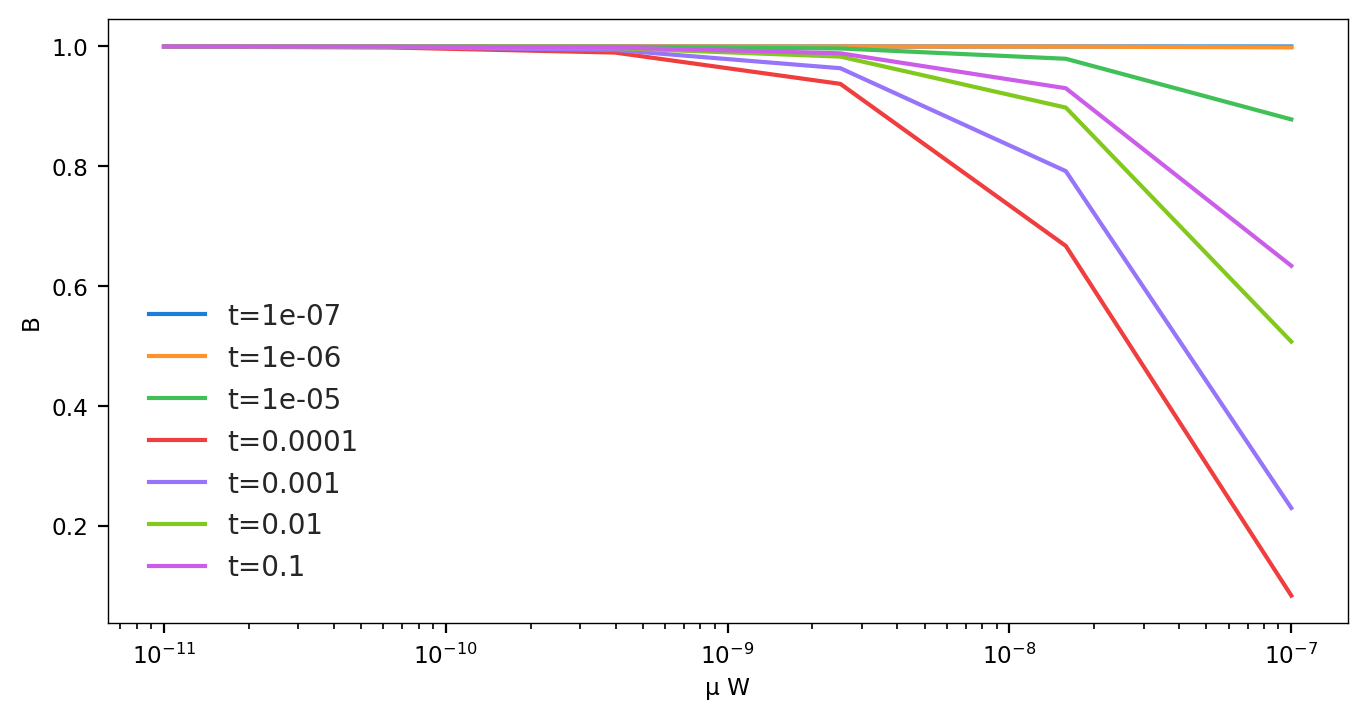

In [8]:
for i, t in enumerate(gm.t):
    plt.plot(gm.w, np.exp(bp[10, :, i, 1]), label=f"t={t}")
    plt.semilogx()
    plt.ylabel('B')
    plt.xlabel('μ W')
plt.legend()

### Experiments

In [9]:
from bgspy.likelihood import negll_simplex_full, negll_softmax_full
from functools import partial

In [10]:
MU_SCALE = 1e-8
PI_SCALE = 1e-4

def negll_simplex_rescaled(theta_scaled, grad, Y, B, w):
    mu = theta_scaled[1] * MU_SCALE
    pi0 = theta_scaled[0] * PI_SCALE
    theta = np.copy(theta_scaled)
    theta[1] = mu
    theta[0] = pi0
    return negll_softmax_full(theta, grad, Y, B, w)
    #return negll_simplex_full(theta, grad, Y, B, w)

def rescale_start(theta):
    theta_scaled = np.copy(theta)
    theta_scaled[0] = theta_scaled[0] / PI_SCALE
    theta_scaled[1] = theta_scaled[1] / MU_SCALE
    for i in range(2, len(theta)-2):
        theta_scaled[i] = np.random.normal(0, 1, 1)
    return theta_scaled


In [11]:
mb = SimplexModel(w=gm.w, t=gm.t, logB=bp, Y=Y,
                  bins=bgs_bins, features=features) 

In [12]:
#simplex_bounds = list(zip(*(rescale_start(mb.bounds()[0]), rescale_start(mb.bounds()[1]))))
simplex_bounds = list(zip(*(mb.bounds()[0], mb.bounds()[1])))
simplex_bounds[2:] = [(None, None)]*(len(simplex_bounds)-2)
#simplex_bounds = [(None, None)]*(len(simplex_bounds))
simplex_bounds

[(0.0004999999999999999, 0.004999999999999999),
 (9.000000000000006e-09, 4.999999999999999e-08),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None)]

In [37]:
import multiprocessing
import tqdm
def opt(start):
    return minimize(partial(negll_softmax_full, grad=None, Y=Y, B=bp, w=gm.w), 
             bounds=simplex_bounds, 
             options={
                 #'maxiter': 1e6,
                 #'xatol': 1e-8,
                 #'adaptive': True,
                 #'fatol':1000
             },
             x0=start, 
             method='L-BFGS-B'
             #method='Nelder-Mead'                   
            )

In [38]:
%%time 
NS = 1000
with multiprocessing.Pool(70) as p:
    a = list(tqdm.tqdm(p.imap(opt, [mb.random_start() for r in range(NS)]), total=NS))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:41<00:00,  9.83it/s]


CPU times: user 2.67 s, sys: 15 s, total: 17.7 s
Wall time: 1min 57s


In [43]:
nlls = np.array([r.fun for r in a])
nll_idx = np.argsort(nlls)
min_i = nll_idx[1]
nlls[min_i]

322751748709.2457

In [24]:
nlls = [r.fun for r in a]
nll_idx = np.argsort(nlls)
min_i = nll_idx[0]
nlls[min_i]

322759448656.591

In [42]:
a[nll_idx[1]].message

'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [53]:
nlls = [r.fun for r in a]
min_i = np.argmin(nlls)
nlls[min_i]

322735424891.74915

In [54]:
nlls = [r.fun for r in a]
nll_idx = np.argsort(nlls)
min_i = nll_idx[0]
nlls[min_i]

322735424891.74915

In [44]:
#a[min_i].x[0] * MU_SCALE, a[min_i].x[1] * PI_SCALE
a[min_i].x[0], a[min_i].x[1]

(0.0014636418929330208, 2.7903502310574973e-08)

In [45]:
a[min_i].x[2:].reshape(mb.nt, mb.nf)

array([[ 0.86705008, -0.51857057,  0.43864444],
       [ 0.90652885, -0.70132986,  0.3888184 ],
       [ 0.50515494, -1.00372391,  0.17782261],
       [-2.00293369, -2.45138605, -1.81181919],
       [-0.69440727,  2.10576821, -0.14686096],
       [ 0.37813541,  2.26935982,  0.4576493 ],
       [ 1.05430016,  1.26091292,  1.47998289]])

In [46]:
np.seterr(under='ignore')
np.round(softmax(a[nll_idx[0]].x[2:].reshape(mb.nt, mb.nf), axis=0), 2)

array([[0.07, 0.  , 0.04],
       [0.09, 0.  , 0.03],
       [0.06, 0.  , 0.03],
       [0.02, 0.01, 0.03],
       [0.04, 0.22, 0.05],
       [0.1 , 0.63, 0.14],
       [0.62, 0.13, 0.68]])

In [29]:
mb.features

['cds', 'phastcons', 'utr']

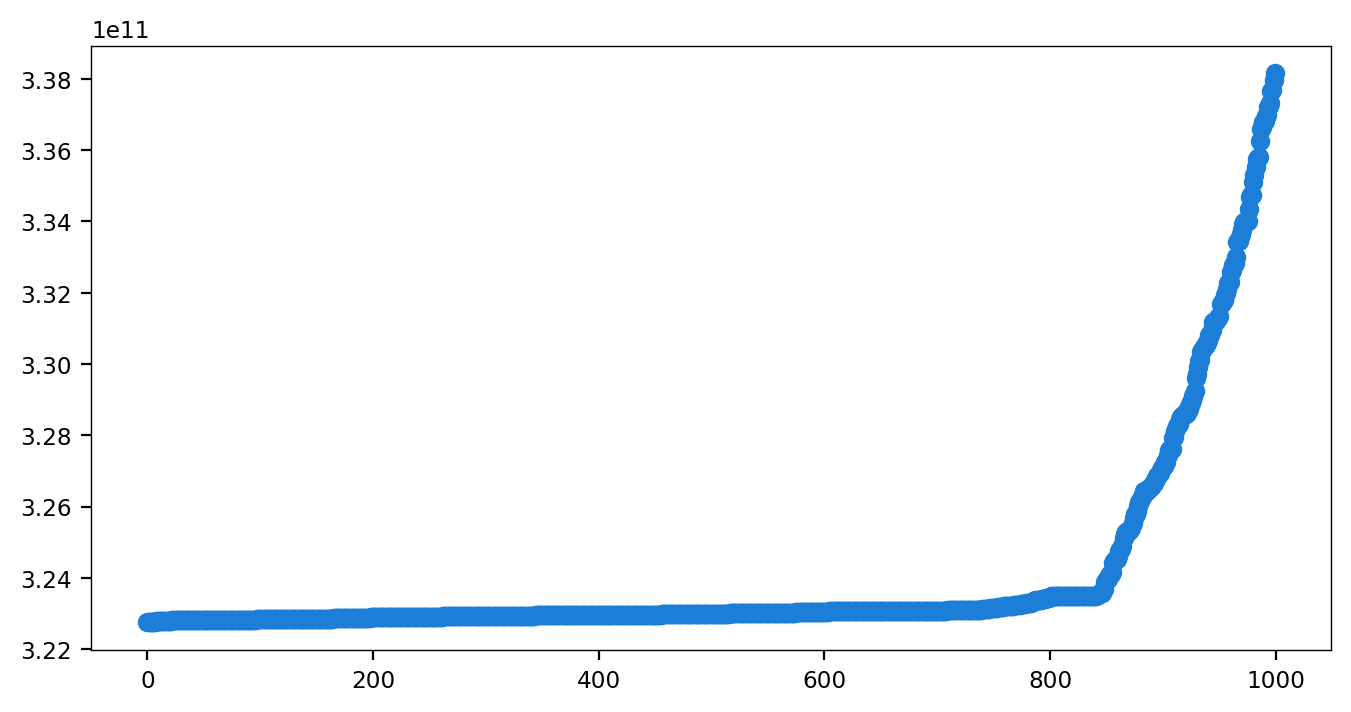

In [30]:
plt.scatter(np.arange(len(nlls)), np.sort(nlls))

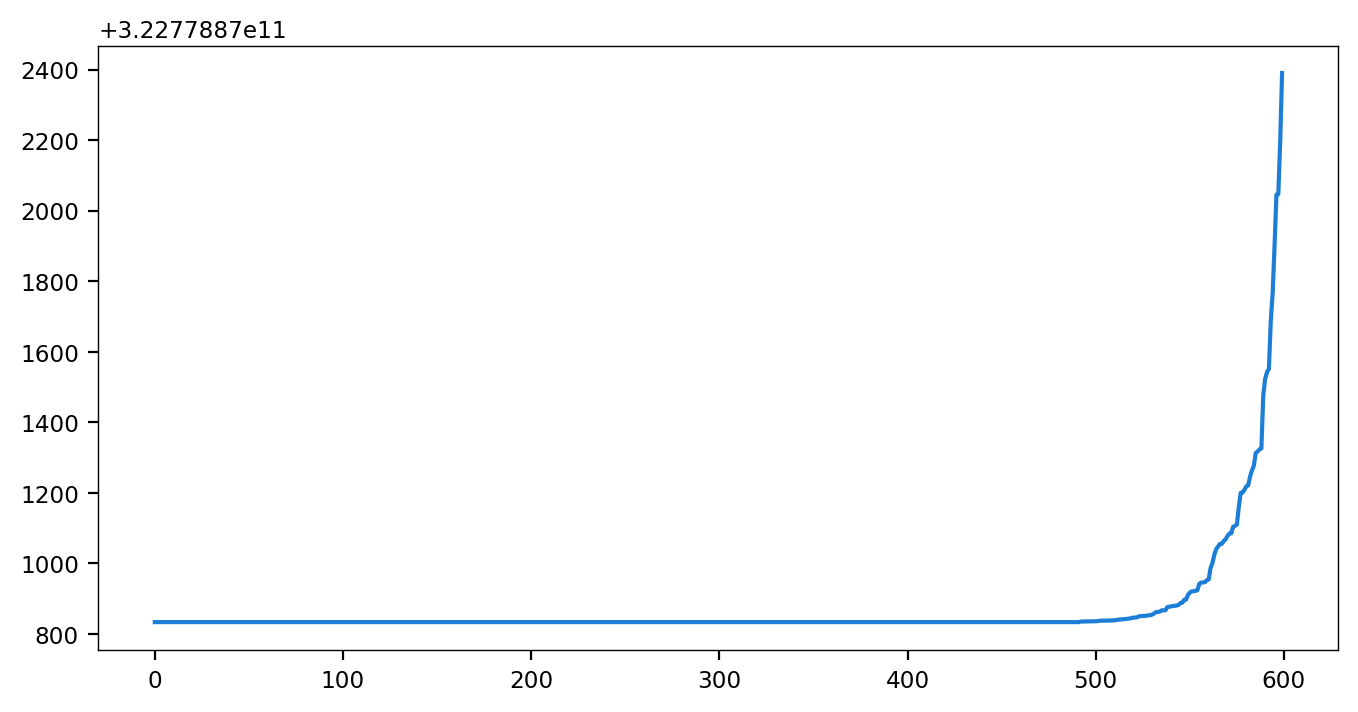

In [148]:
plt.plot(nlls[nll_idx][:-400])

In [ ]:
mb.fit(ncores=70, starts=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [156]:
mb

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 322778881468.1073
π0 = 0.0015809669217158456
μ = 4.9593429378543405e-08
R² = 66.6278
W = 
          undefined
------  -----------
1e-07         0.394
1e-06         0.002
1e-05         0
0.0001        0
0.001         0.129
0.01          0.058
0.1           0.418

In [152]:
def convert_softmax(theta_sm):
    theta = np.copy(theta_sm)
    theta[2:] = softmax(theta[2:].reshape(mb.nt, mb.nf), axis=0).flat
    return theta

mb.theta_ = mb.random_start() #convert_softmax(a[-1].x)
mb.nll_ = nlls[min_i]

(<Figure size 1600x800 with 1 Axes>, <AxesSubplot: >)

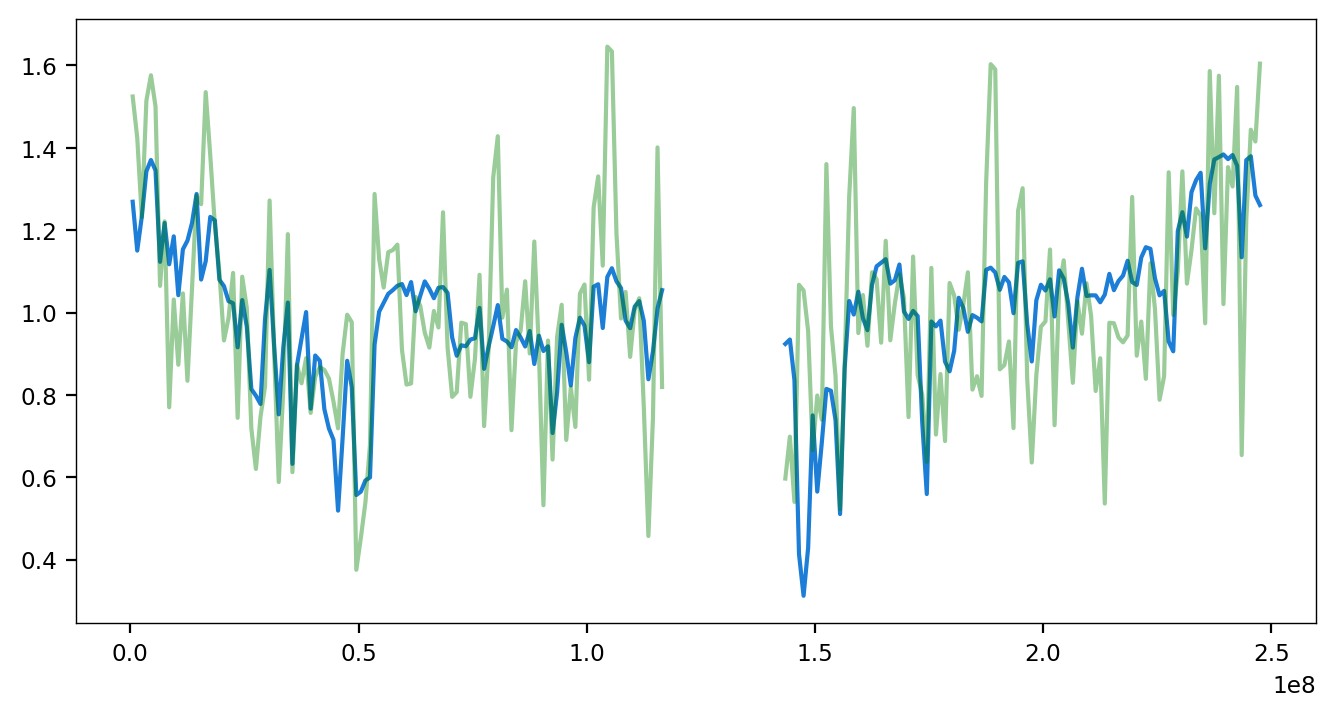

In [162]:
mb.predict_plot('chr1')

In [120]:
mb.random_start()

array([3.00373284e-03, 4.49063748e-08, 4.51957359e-03, 9.89819609e-02,
       2.95522479e-02, 9.82467925e-02, 2.11818661e-02, 6.93224753e-02,
       1.28689300e-01, 5.63727464e-02, 4.13350479e-02, 1.90677066e-01,
       5.51512340e-01, 2.25795371e-01, 4.95195952e-02, 1.97167530e-02,
       4.26084580e-01, 5.03957672e-01, 7.48539227e-02, 1.67132781e-01,
       2.43900004e-02, 1.77380411e-01, 4.07774976e-02])

(<Figure size 1600x800 with 1 Axes>,
 <AxesSubplot: xlabel='predicted $\\hat{\\pi}$', ylabel='residuals'>)

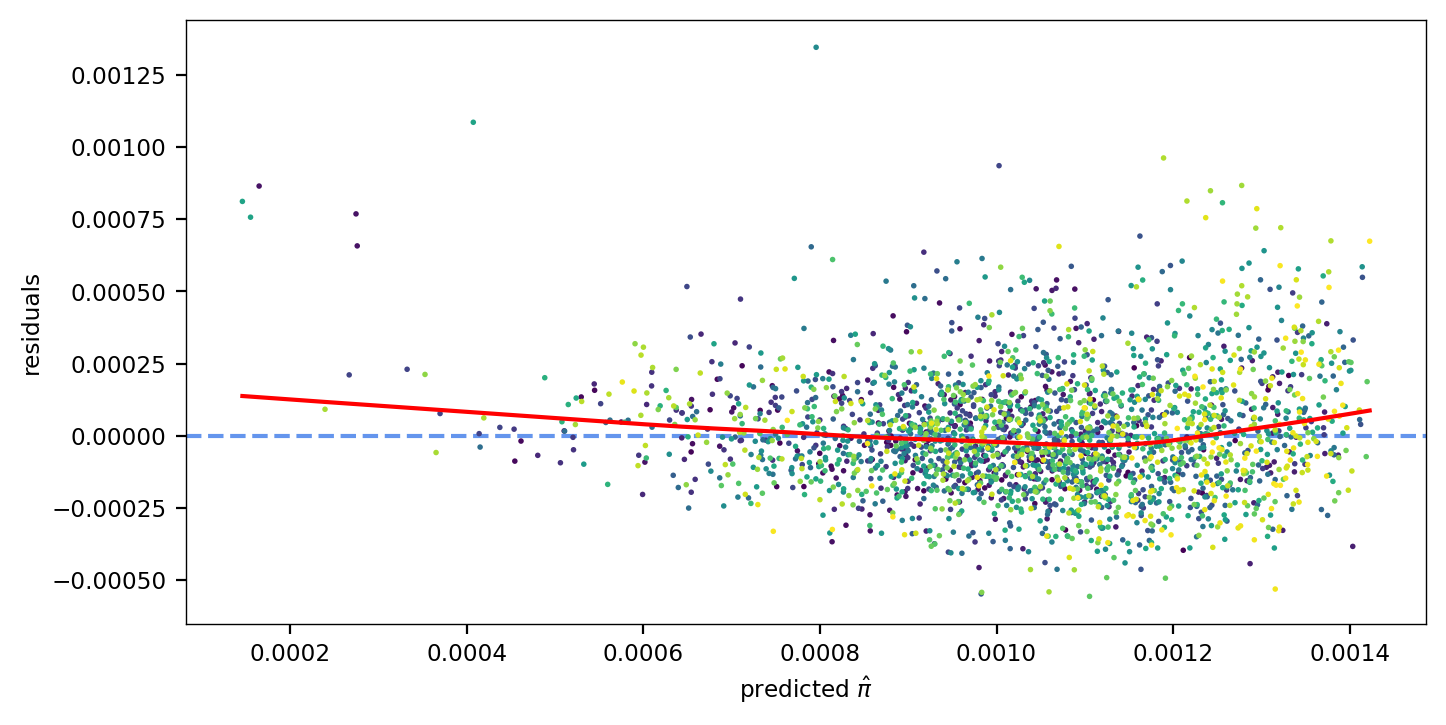

In [75]:
mb.resid_fitted_plot()

In [110]:
mb

MLE (interpolated w): 6 x 7 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 322735424891.74915
π0 = 0.003667144261872933
μ = 4.067036786446281e-08
R² = 66.4897
W = 
          cds    phastcons    utr
------  -----  -----------  -----
1e-07   0.071        0.008  0.017
1e-06   0.013        0.144  0.06
1e-05   0.065        0.012  0.06
0.0001  0.124        0.092  0.159
0.001   0.02         0.019  0.183
0.01    0.508        0.472  0.475
0.1     0.2          0.252  0.046

In [ ]:
%%time 
m_b.fit(ncores=50, starts=2000, start_pi0=0.0015, start_mu=3e-8, algo='GN_ISRES')

  0%|          | 0/2000 [00:00<?, ?it/s]

In [12]:
m_b

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 322778981134.79486
π0 = 0.0015828847741328883
μ = 3.004491975885917e-08
R² = 66.6259
W = 
          undefined
------  -----------
1e-07         0
1e-06         0.001
1e-05         0
0.0001        0
0.001         0.215
0.01          0.084
0.1           0.701

In [14]:
m_b.optim

OptimResult
  termination code: xtol reached
  stats: {'xtol reached': 1992, 'max eval': 8} (prop success: 100.0%)
  negative log-likelihood = 322778981134.79486
  theta = [1.58288477e-03 3.00449198e-08 3.60169419e-04 5.06109943e-04
 2.42576328e-05 2.81284967e-04 2.14794012e-01 8.35385118e-02
 7.00650041e-01]

In [11]:
m_b

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 322778994608.46765
π0 = 0.001582883595483872
μ = 4.496758587745205e-08
R² = 66.6214
W = 
          undefined
------  -----------
1e-07         0.313
1e-06         0.018
1e-05         0
0.0001        0
0.001         0.142
0.01          0.061
0.1           0.465

In [50]:
m_b

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 322778986520.9623
π0 = 0.0015824358718647073
μ = 3.281030904802272e-08
R² = 66.6248
W = 
          undefined
------  -----------
1e-07         0.071
1e-06         0.014
1e-05         0
0.0001        0
0.001         0.196
0.01          0.079
0.1           0.639

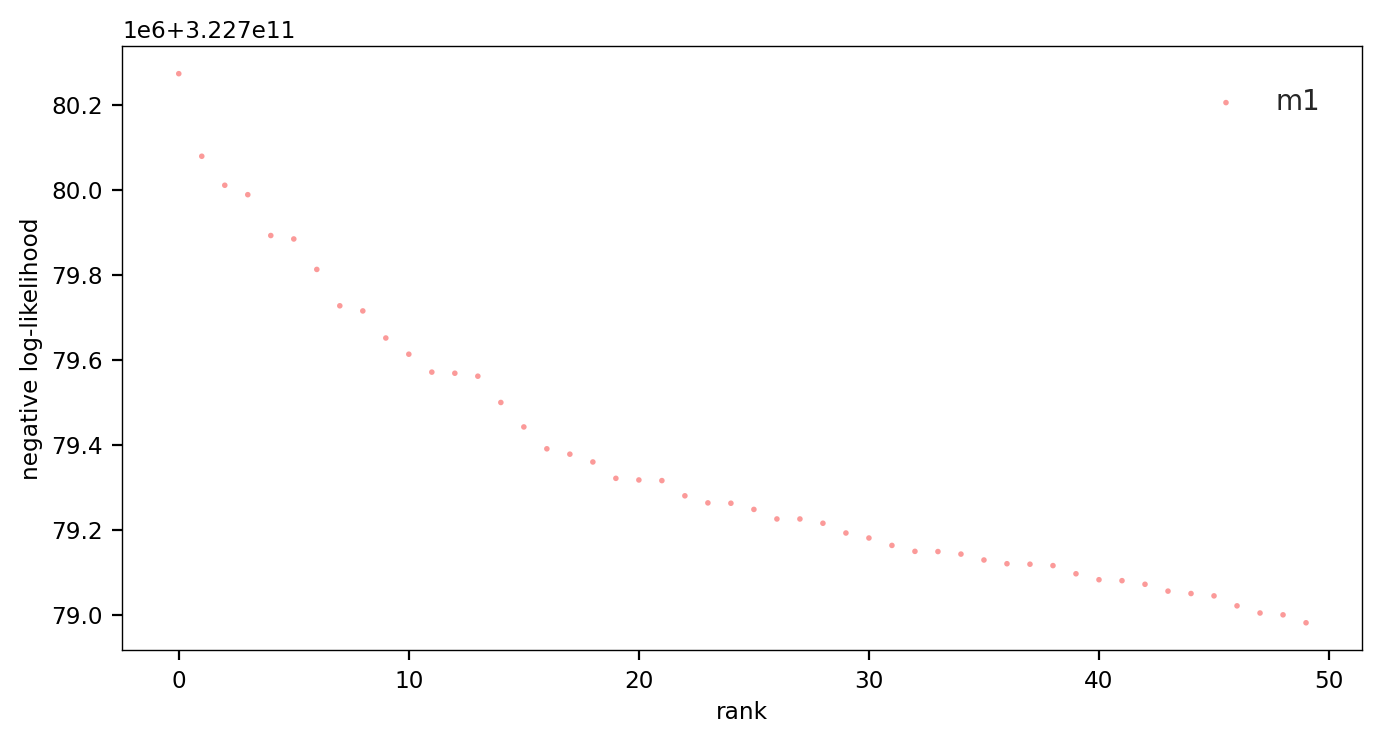

In [17]:
optim_plot(m1=mb.optim)

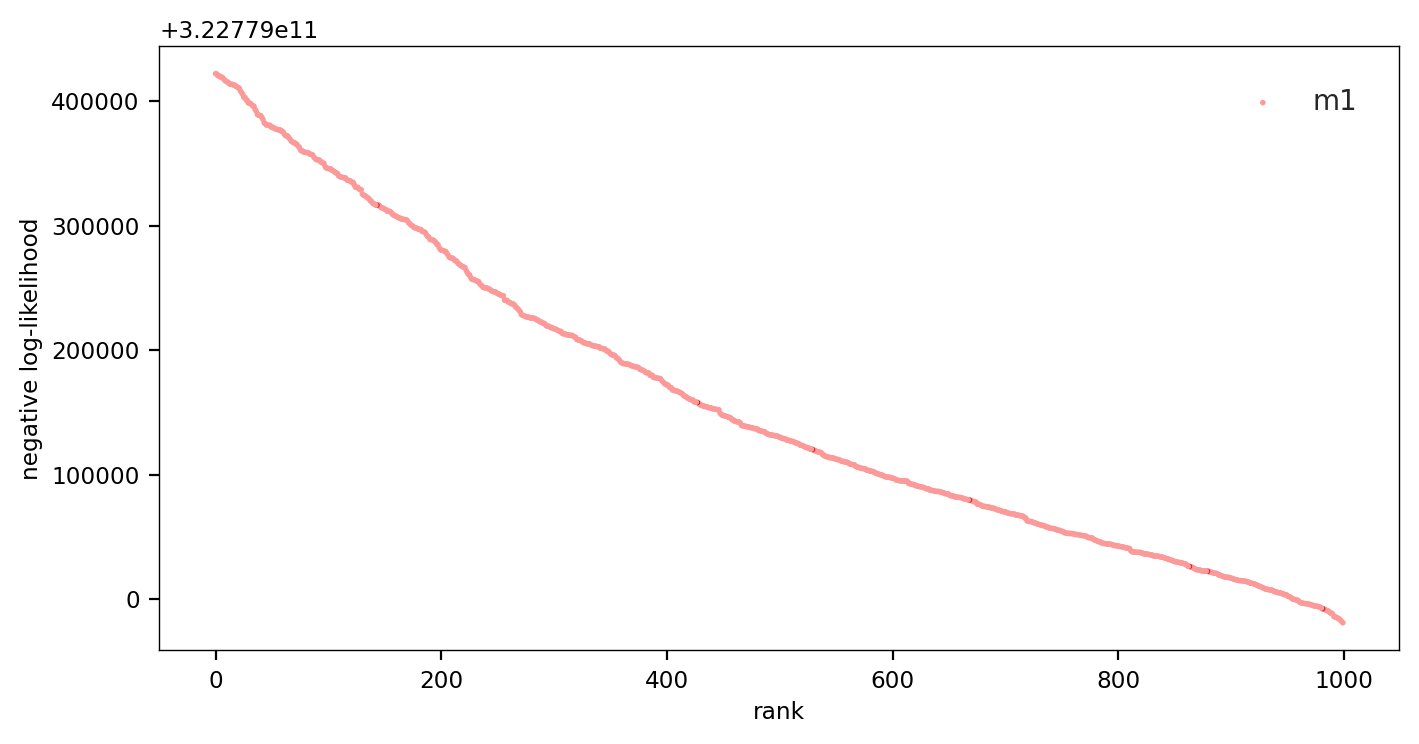

In [13]:
optim_plot(m1=m_b.optim)

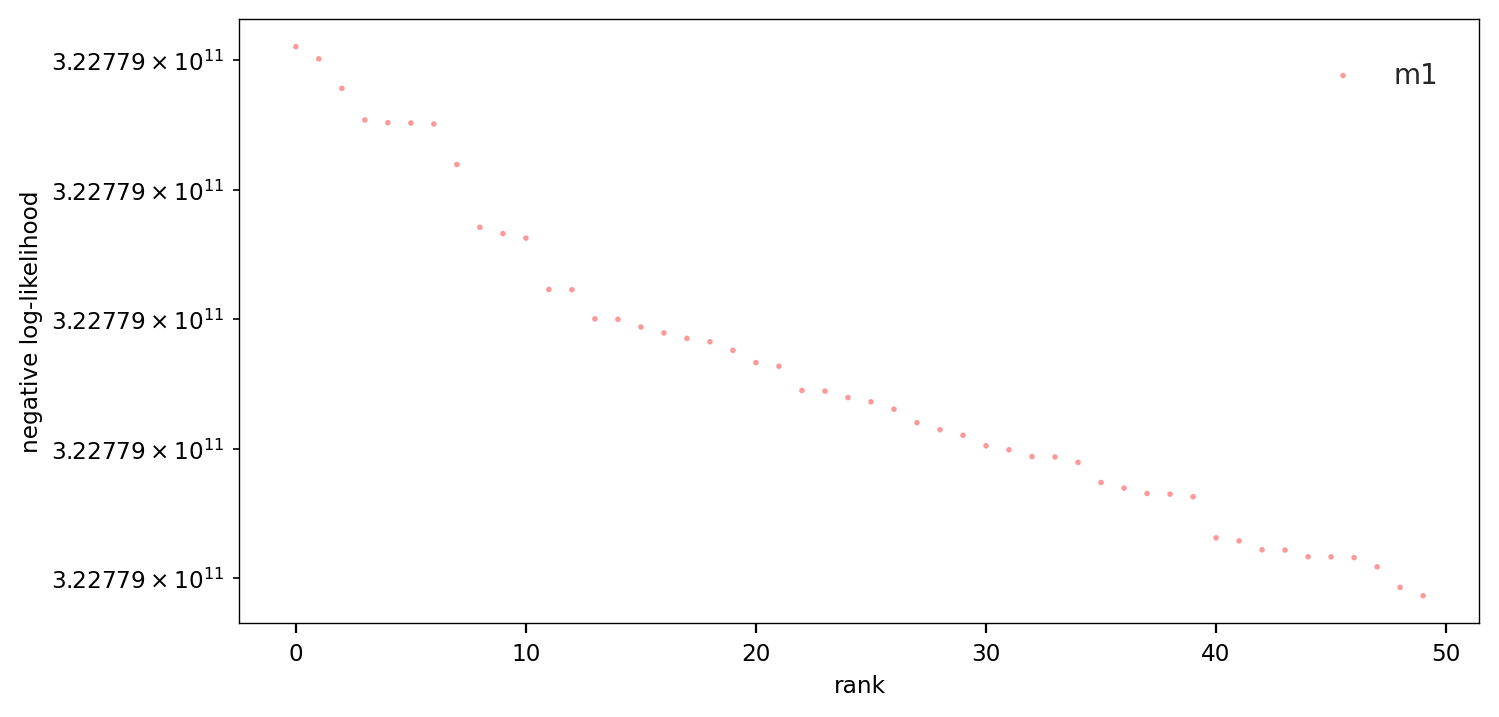

In [56]:
optim_plot(m1=m_b.optim)

In [15]:
m_b.fit(ncores=50, starts=1, start_pi0=0.0015, start_mu=3e-8, algo='GN_ISRES')

  0%|          | 0/1 [00:00<?, ?it/s]

> /home/vsb/projects/bprime/bgspy/optim.py(188)nlopt_simplex_worker()
    186     log10_mu_bounds = bounds[0][1], bounds[1][1]  # TODO CHECK
    187     __import__('pdb').set_trace()
--> 188     hl, hu = inequality_constraint_functions(nt, nf, mu=mu, 
    189                                              log10_mu_bounds=log10_mu_bounds)
    190     # tolerances for inequality constraint



ipdb>  log10_mu_bounds


(1e-11, 1e-07)


ipdb>  exit


BdbQuit: 

### CDS + UTRs + Phastcons Model

In [ ]:
fd = load_pickle('../fits/hg38_cds_utrs_phastcons_simplex/model_data.pkl')
gm, Y, bgs_bins, features, bp = fd['gm'], fd['Y'], fd['bgs_bins'], fd['gm'], fd['bp']

In [32]:
10**np.array(tuple(np.log10((0.0005, 0.005))))

array([0.0005, 0.005 ])

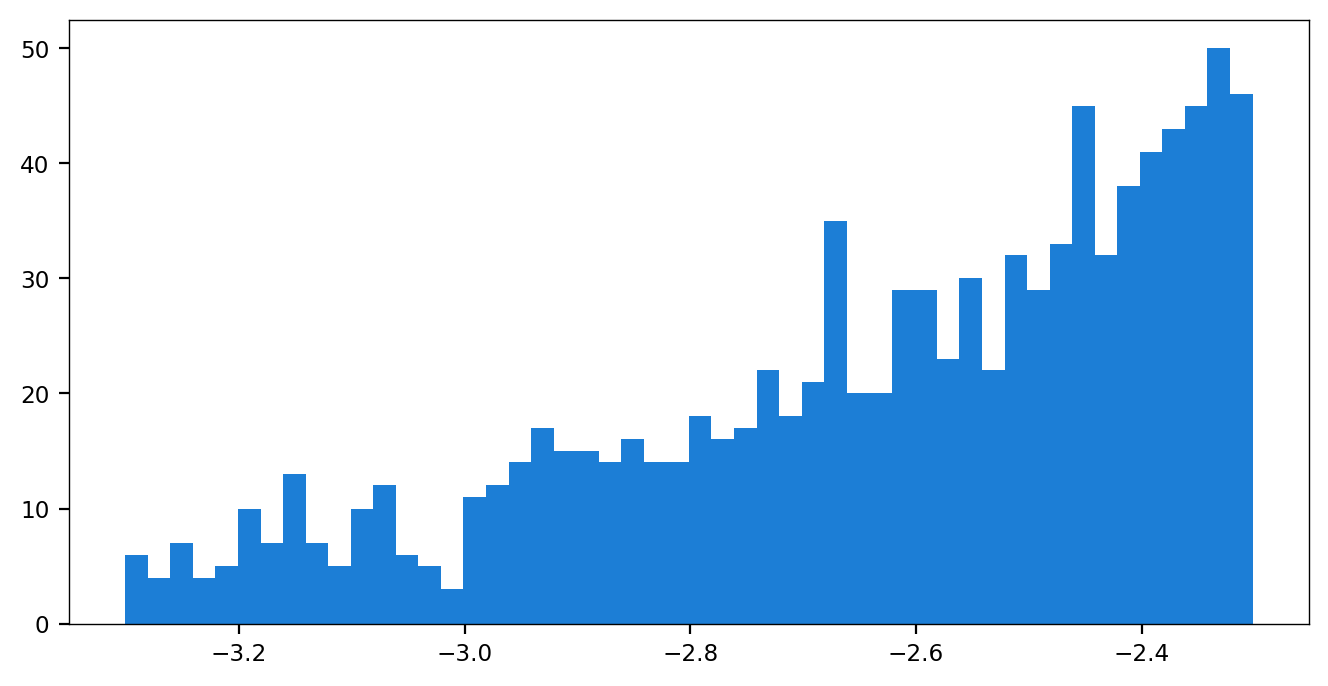

In [44]:
_ = plt.hist(np.log10([m_b.random_start()[0] for x in range(1000)]), 50)

In [39]:
from bgspy.data import pi_from_pairwise_summaries
pi_from_pairwise_summaries(Y.sum(axis=0))

0.001052746703898515

In [18]:
m_b

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 322791293316.3191
π0 = 0.0015787476785369746
μ = 6.407820745658771e-08
R² = 66.2317
W = 
          undefined
------  -----------
1e-07         0.022
1e-06         0.393
1e-05         0.127
0.0001        0
0.001         0.064
0.01          0.112
0.1           0.281

In [21]:
m_b

MLE (interpolated w): 6 x 7 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 322741693444.99133
π0 = 0.001559728773284351
μ = 3.855877895183788e-08
R² = 67.8068
W = 
          cds    phastcons    utr
------  -----  -----------  -----
1e-07   0.32         0.055  0.241
1e-06   0.228        0.007  0.202
1e-05   0.008        0.003  0.133
0.0001  0.001        0.001  0.02
0.001   0.001        0.148  0.063
0.01    0.266        0.414  0.196
0.1     0.177        0.372  0.146

In [10]:
%%time
m_b.fit(ncores=70, starts=100, algo='GN_ISRES')

  0%|          | 0/100 [00:00<?, ?it/s]

Process ForkPoolWorker-140:
Process ForkPoolWorker-136:
Process ForkPoolWorker-117:
Process ForkPoolWorker-88:
Process ForkPoolWorker-125:


KeyboardInterrupt: 